🩺
# Heart Failure Dataset: Advanced EDA, Survival, and Modeling Notebook
**Author:** Cholpon Zhakshylykova  
**Data:** heart_failure.csv  
**Goal:** Understand, visualize, and engineer features prior to modeling.


In [59]:
# 1. Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
import math
import os

sns.set_palette("husl")
plt.style.use('seaborn-v0_8')
os.makedirs('plots', exist_ok=True)


## 2. Data Loading & Initial Checks
- Shape, info, missing values, duplicates
- Quick view of data

In [78]:
# 2. Load Data & Initial Checks
df = pd.read_csv('heart_failure.csv')
print(f"Shape: {df.shape}")
df.info()
display(df.head())

#missing data
if df.isnull().values.any():
    print("Missing data detected.")
else:
    print("No missing data found.")

# Check for duplicates
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count}")
if dup_count > 0:
    display(df[df.duplicated()])
else:
    print("No exact duplicates found.")


Shape: (299, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


No missing data found.
Duplicate rows: 0
No exact duplicates found.


## 3. Feature Descriptions

**Clinical Meaning Reference**  
(Feel free to delete this cell after EDA if you want a tighter report!)


In [20]:
feature_descriptions = {
    'age': 'Age of the patient (years)',
    'anaemia': 'Decrease of red blood cells or hemoglobin (boolean)',
    'creatinine_phosphokinase': 'Level of CPK enzyme in blood (mcg/L)',
    'diabetes': 'If the patient has diabetes (boolean)',
    'ejection_fraction': 'Percentage of blood leaving the heart at each contraction (%)',
    'high_blood_pressure': 'If patient has hypertension (boolean)',
    'platelets': 'Platelets in blood (kiloplatelets/mL)',
    'serum_creatinine': 'Level of serum creatinine in the blood (mg/dL)',
    'serum_sodium': 'Level of serum sodium in the blood (mEq/L)',
    'sex': '1 = Male, 0 = Female',
    'smoking': 'If the patient smokes (boolean)',
    'time': 'Follow-up period (days)',
    'DEATH_EVENT': 'If patient died during follow-up (boolean, target)'
}
for k,v in feature_descriptions.items():
    print(f"{k}: {v}")


age: Age of the patient (years)
anaemia: Decrease of red blood cells or hemoglobin (boolean)
creatinine_phosphokinase: Level of CPK enzyme in blood (mcg/L)
diabetes: If the patient has diabetes (boolean)
ejection_fraction: Percentage of blood leaving the heart at each contraction (%)
high_blood_pressure: If patient has hypertension (boolean)
platelets: Platelets in blood (kiloplatelets/mL)
serum_creatinine: Level of serum creatinine in the blood (mg/dL)
serum_sodium: Level of serum sodium in the blood (mEq/L)
sex: 1 = Male, 0 = Female
smoking: If the patient smokes (boolean)
time: Follow-up period (days)
DEATH_EVENT: If patient died during follow-up (boolean, target)


## 4. Descriptive Statistics & class balance



,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000
mean,60.833893,581.839465,38.083612,263358.029264,1.39388,136.625418,130.260870
std,11.894809,970.287881,11.834841,97804.236869,1.03451,4.412477,77.614208
min,40.000000,23.000000,14.000000,25100.000000,0.50000,113.000000,4.000000
25%,51.000000,116.500000,30.000000,212500.000000,0.90000,134.000000,73.000000
50%,60.000000,250.000000,38.000000,262000.000000,1.10000,137.000000,115.000000
75%,70.000000,582.000000,45.000000,303500.000000,1.40000,140.000000,203.000000
max,95.000000,7861.000000,80.000000,850000.000000,9.40000,148.000000,285.000000



Target class balance:
DEATH_EVENT
0    203
1     96
Name: count, dtype: int64
Minority class %: 32.1%


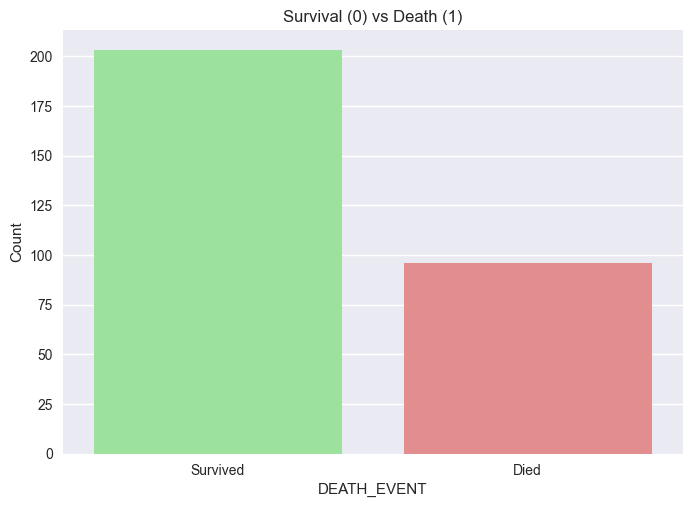

In [79]:
# Numeric summary
display(df[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]].describe())

# Class balance
print("\nTarget class balance:")
print(df['DEATH_EVENT'].value_counts())
print('Minority class %: {:.1f}%'.format(100 * df['DEATH_EVENT'].value_counts(normalize=True)[1]))
sns.countplot(x='DEATH_EVENT', data=df, palette=['lightgreen','lightcoral'])
plt.title('Survival (0) vs Death (1)')
plt.xticks([0,1],['Survived','Died'])
plt.ylabel('Count')
plt.show()


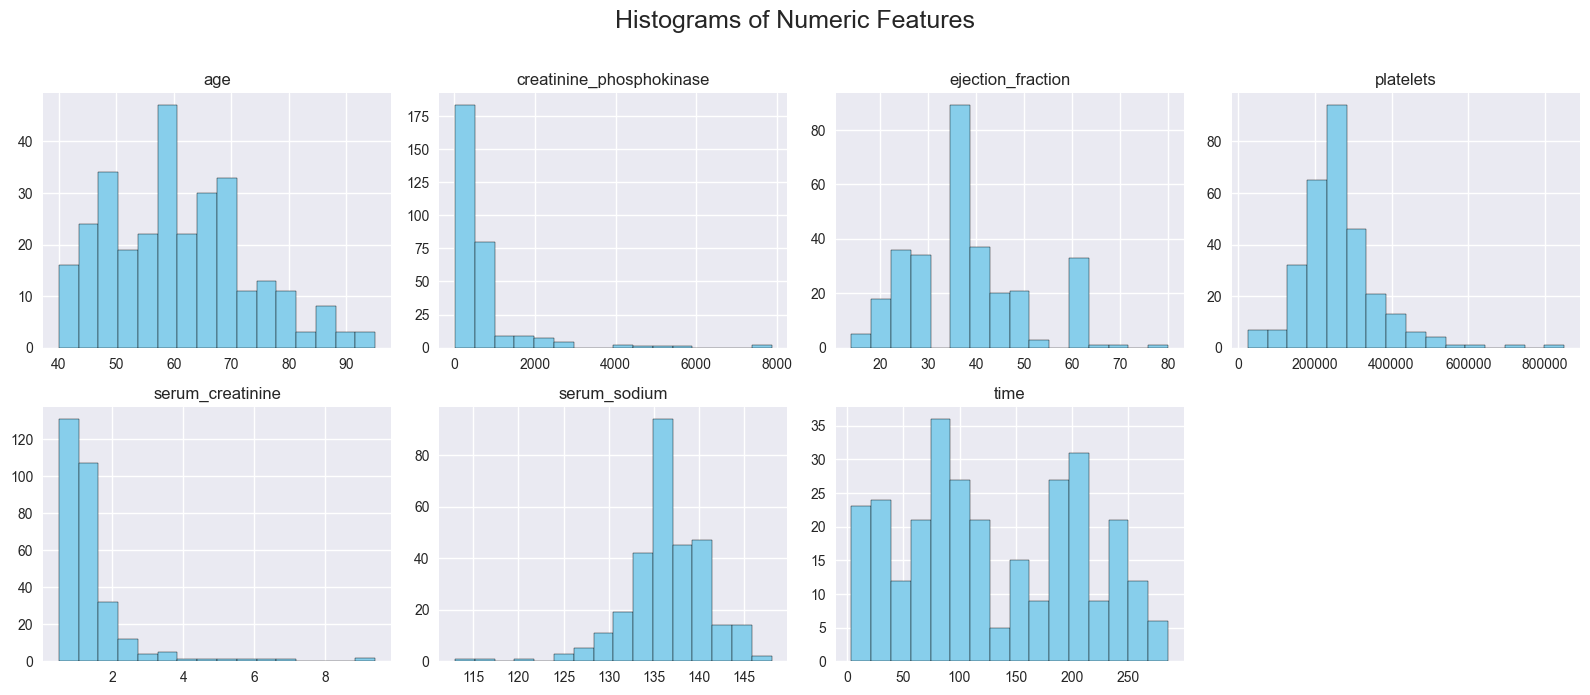

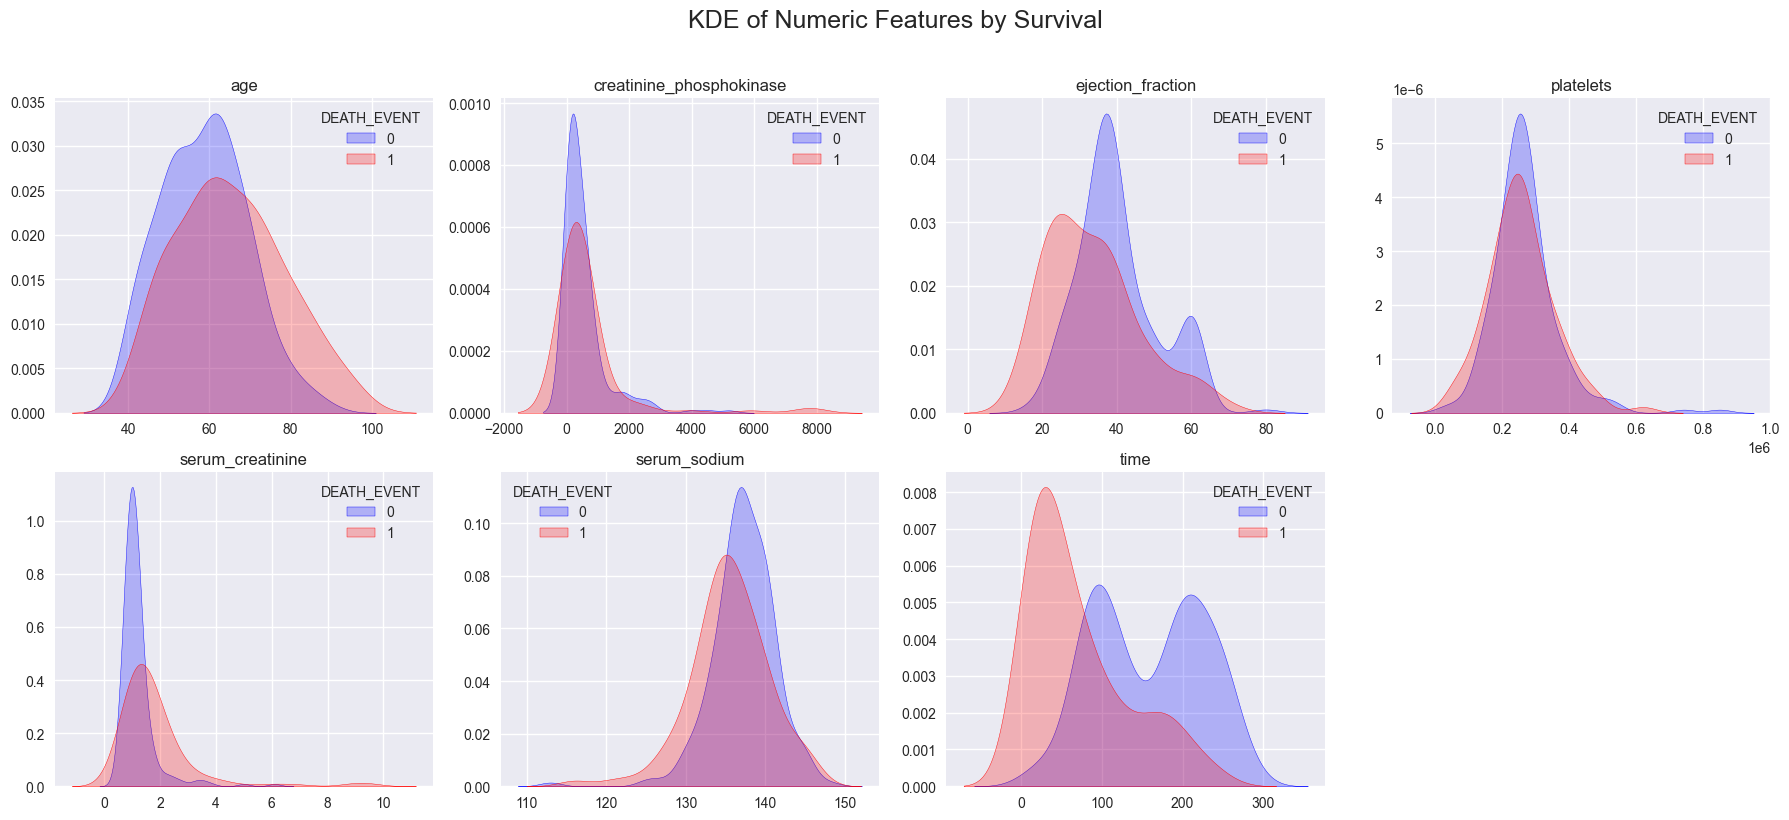

In [60]:
# Histograms for all numerics
numeric_cols = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
df[numeric_cols].hist(bins=16, figsize=(16, 10), layout=(3, 4), color='skyblue', edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

# KDE by target
fig, axes = plt.subplots(math.ceil(len(numeric_cols)/4), 4, figsize=(18, 8))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    [sns.kdeplot(df[df['DEATH_EVENT']==event][col], fill=True, ax=ax, label=event, color=c)
     for event, c in zip([0,1], ['blue','red'])]
    ax.set_title(col)
    ax.legend(title='DEATH_EVENT')
    ax.set_xlabel("")
    ax.set_ylabel("")

[ax.axis('off') for ax in axes[len(numeric_cols):]]  # Hide unused axes

fig.suptitle("KDE of Numeric Features by Survival", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()



## 5. Outlier Checks


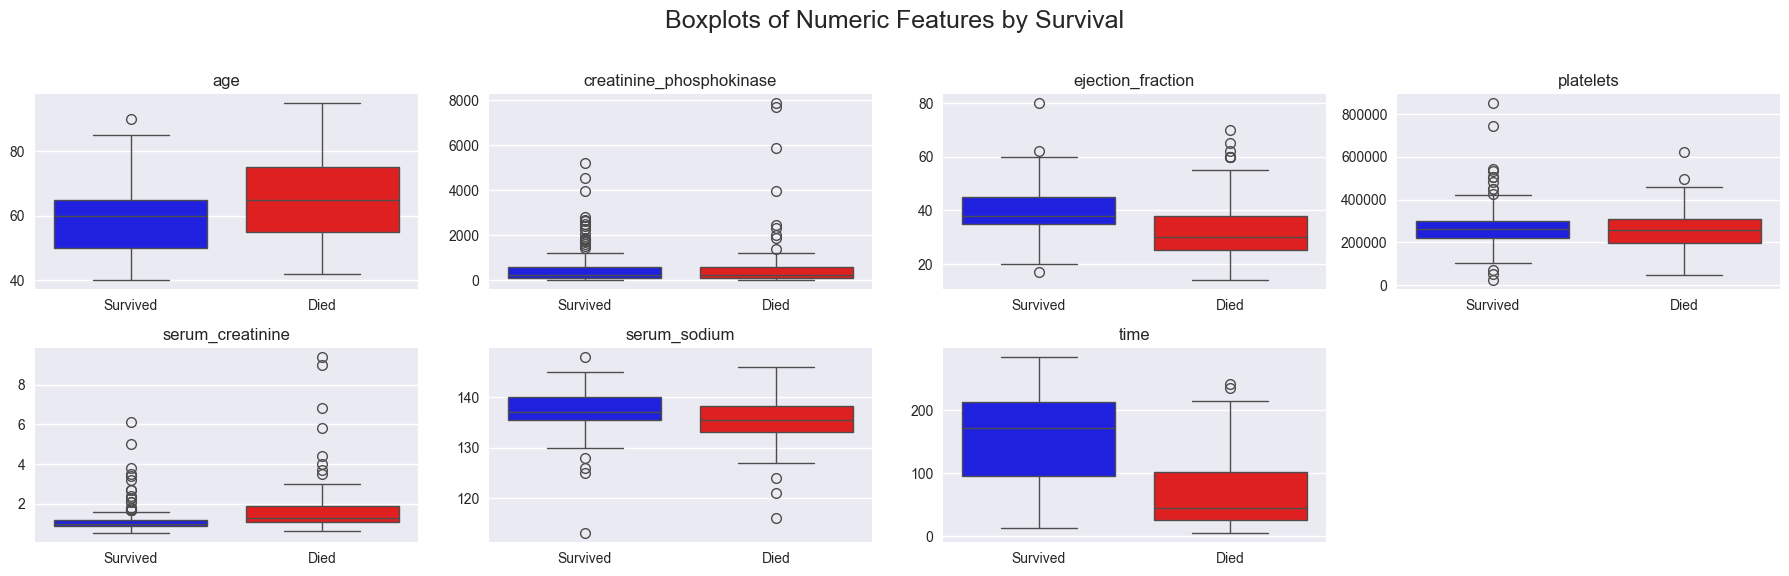

In [63]:


numeric_cols = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]


# --- Boxplots by target, all in one figure ---
ncols, nrows = 4, math.ceil(len(numeric_cols)/4)

fig, axes = plt.subplots(nrows, ncols, figsize=(18, 2.8*nrows))
axes = axes.flatten()

for ax, col in zip(axes, numeric_cols):
    sns.boxplot(x='DEATH_EVENT', y=col, data=df, palette=['blue','red'], ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(['Survived','Died'])
for ax in axes[len(numeric_cols):]:
    ax.axis('off')
fig.suptitle("Boxplots of Numeric Features by Survival", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


## 6. Correlation Analysis


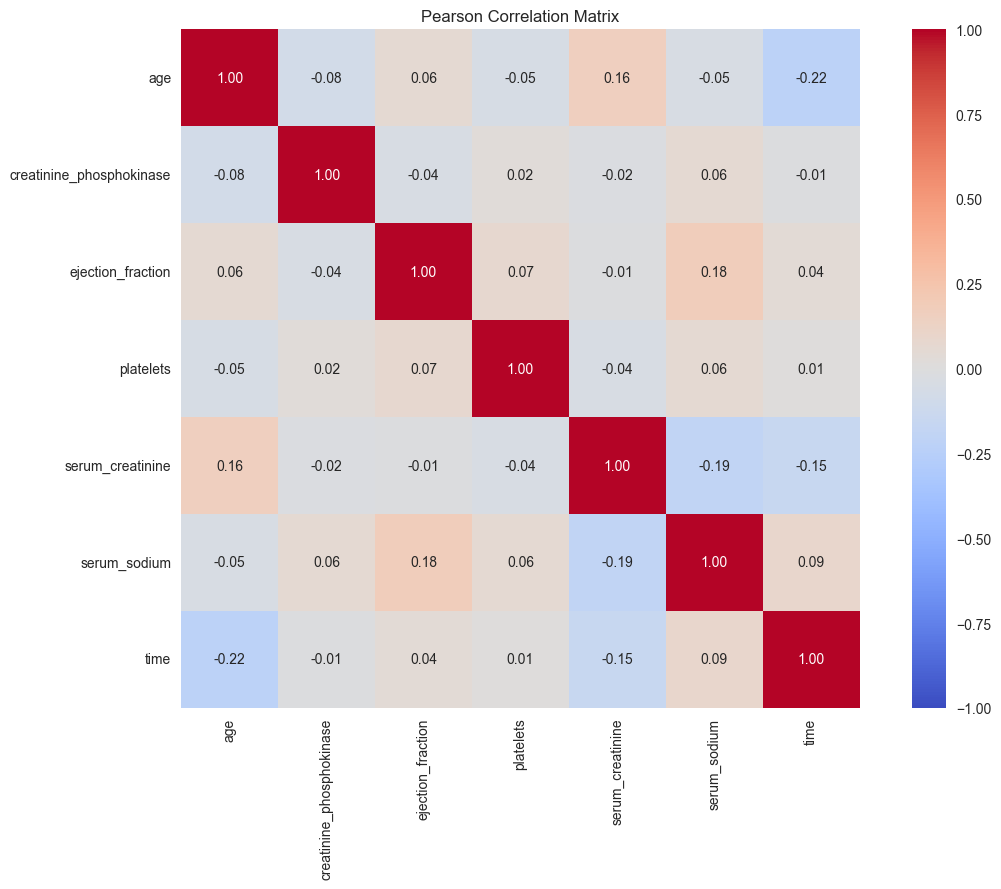

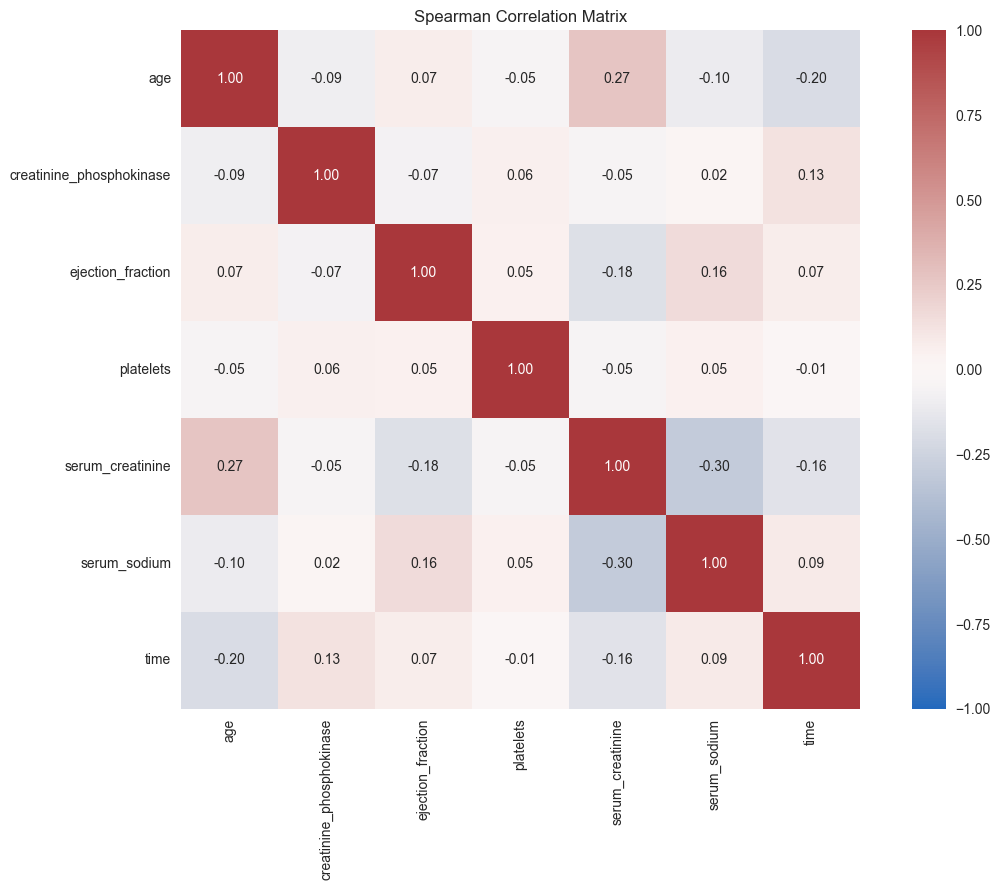

Feature pairs with absolute Pearson correlation > 0.7:


,Feature 1,Feature 2,Correlation



Pearson correlation with DEATH_EVENT:
DEATH_EVENT                 1.000000
serum_creatinine            0.294278
age                         0.253729
creatinine_phosphokinase    0.062728
platelets                  -0.049139
serum_sodium               -0.195204
ejection_fraction          -0.268603
time                       -0.526964
Name: DEATH_EVENT, dtype: float64

Top 5 absolute correlations with DEATH_EVENT:
time                 0.526964
serum_creatinine     0.294278
ejection_fraction    0.268603
age                  0.253729
serum_sodium         0.195204
Name: DEATH_EVENT, dtype: float64


In [65]:
# Pearson heatmap
plt.figure(figsize=(12,9))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, square=True)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()

# Spearman heatmap
plt.figure(figsize=(12,9))
sns.heatmap(df[numeric_cols].corr(method='spearman'), annot=True, fmt=".2f", cmap="vlag", vmin=-1, vmax=1, square=True)
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()

# Highly correlated feature pairs (Pearson, abs > 0.7)
corrmat = df[numeric_cols].corr().abs()
high_corrs = (
    corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)
print("Feature pairs with absolute Pearson correlation > 0.7:")
display(high_corrs[high_corrs['Correlation'] > 0.7].sort_values(by='Correlation', ascending=False))

# Correlation with DEATH_EVENT
corr_target = df[numeric_cols + ['DEATH_EVENT']].corr()['DEATH_EVENT'].sort_values(ascending=False)
print("\nPearson correlation with DEATH_EVENT:")
print(corr_target)
print("\nTop 5 absolute correlations with DEATH_EVENT:")
print(corr_target.drop('DEATH_EVENT').abs().sort_values(ascending=False).head())


## 7. Pairplot and Violin Plots


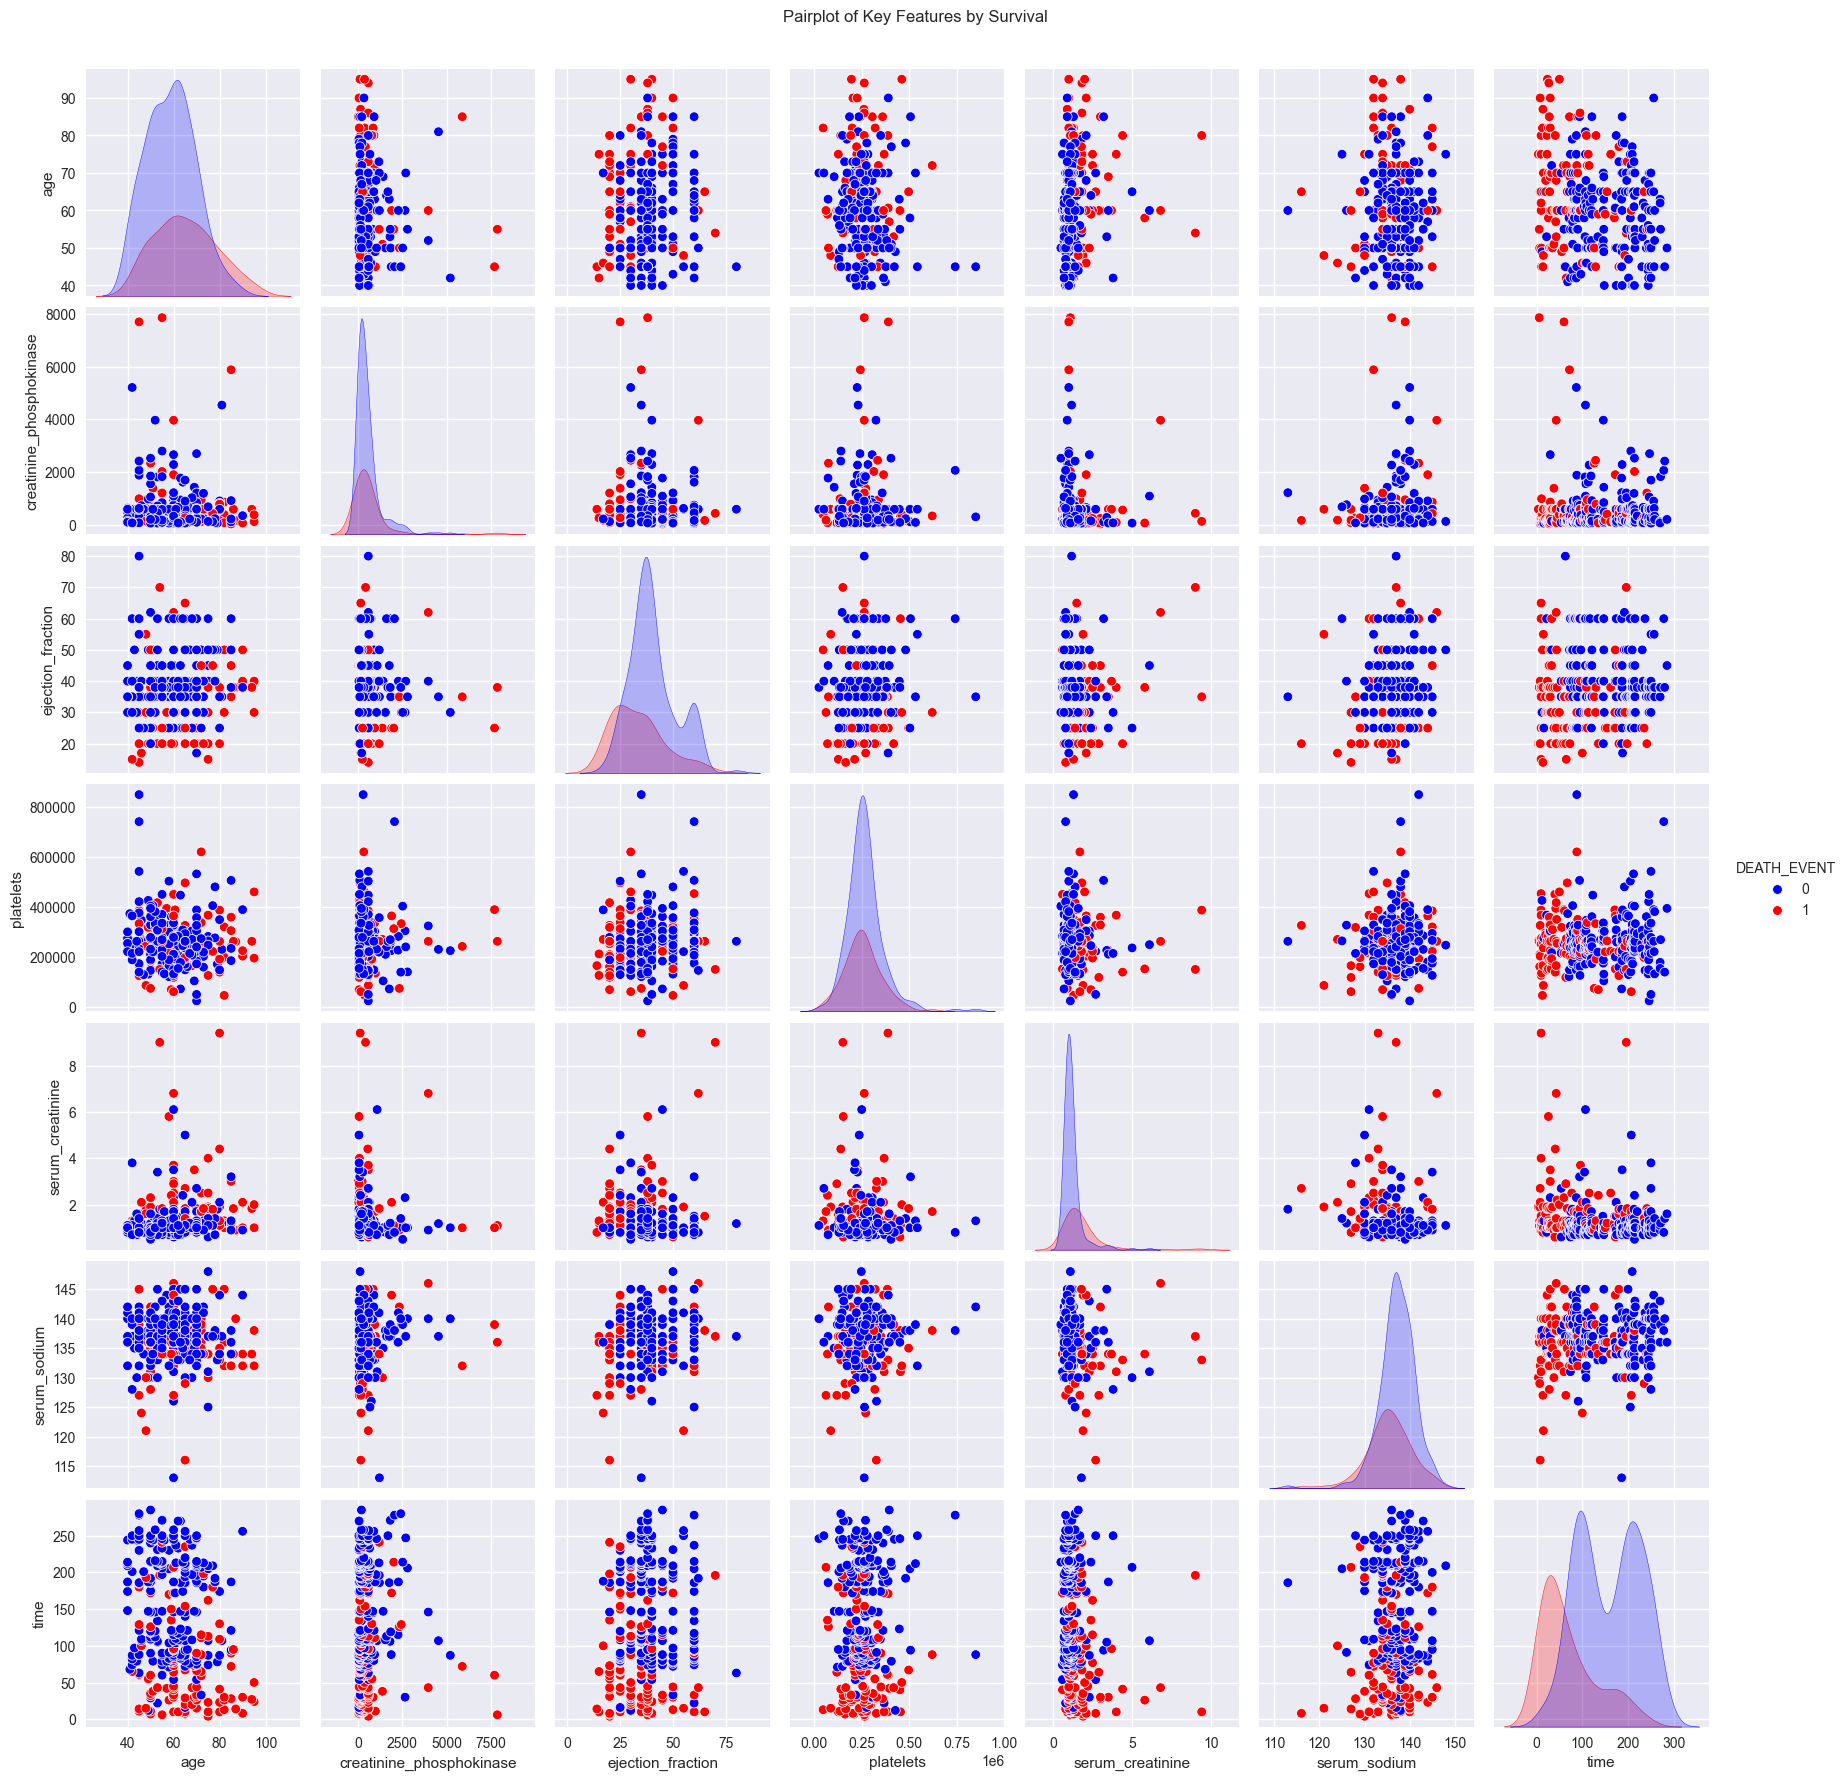

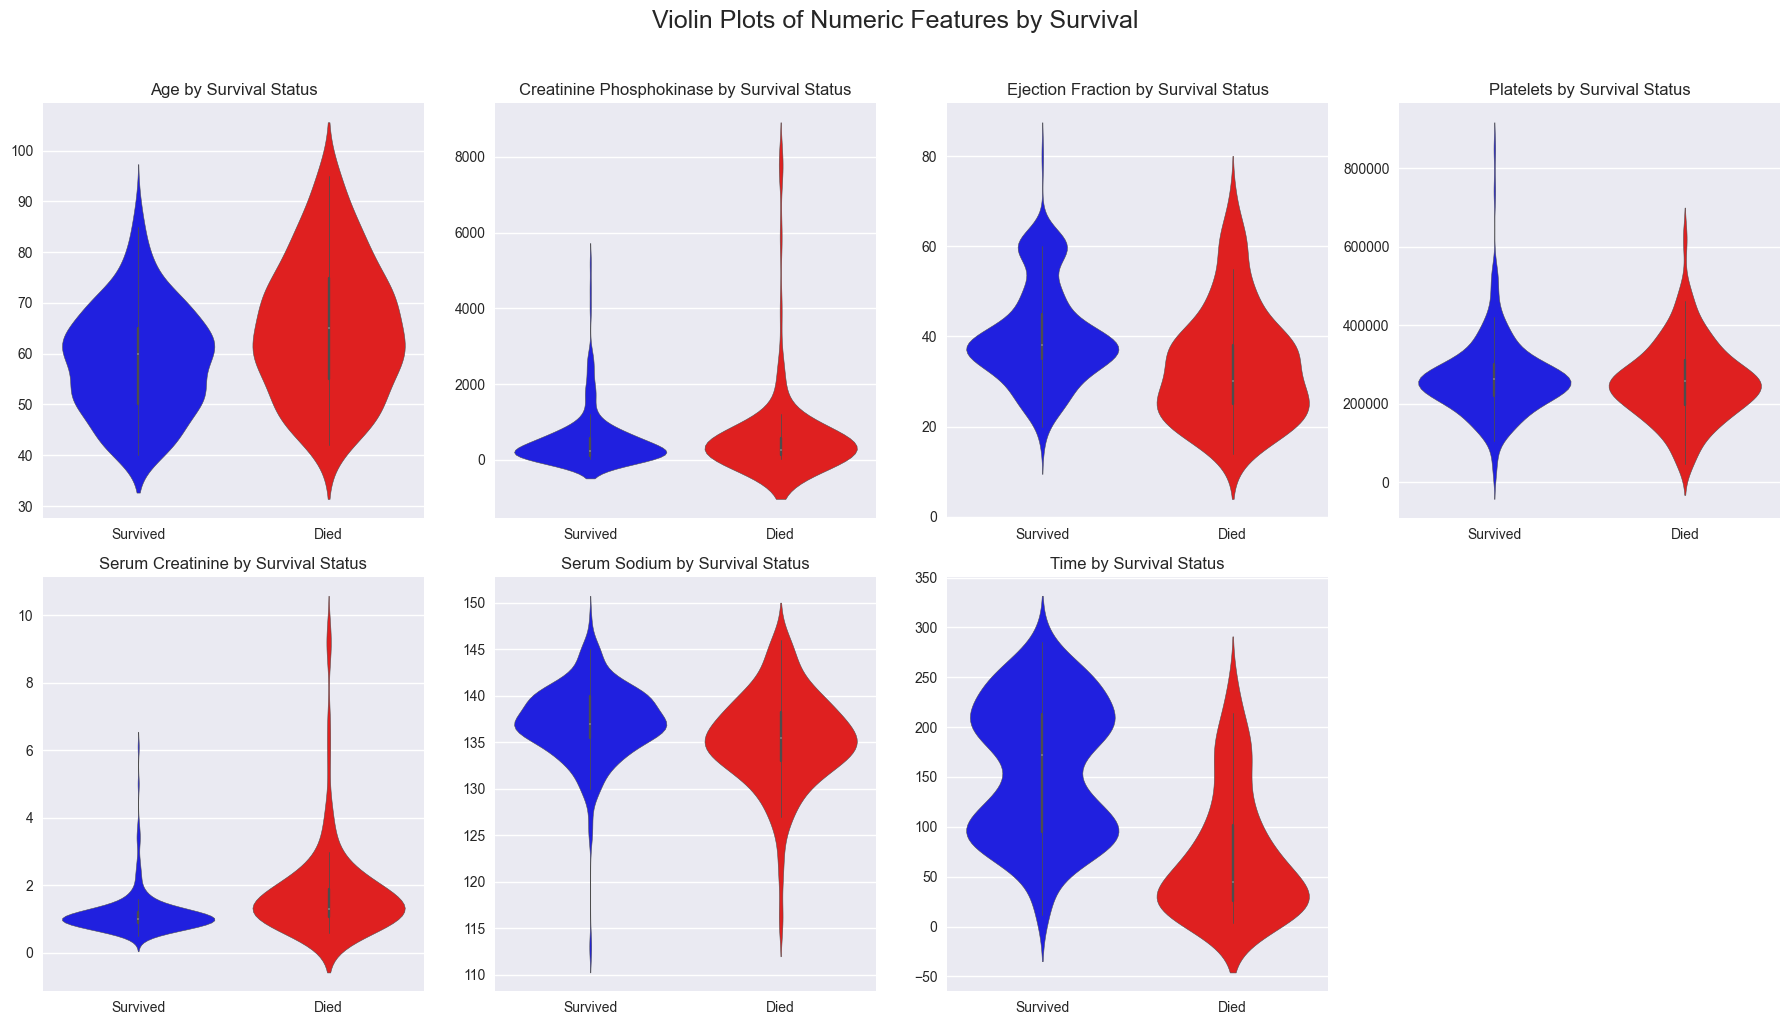

In [68]:
sns.pairplot(df[["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time", "DEATH_EVENT"]],
             hue='DEATH_EVENT', palette=['blue','red'])
plt.suptitle('Pairplot of Key Features by Survival', y=1.02)
plt.show()


# Violin plots for numeric features by target
numeric_cols = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for ax, feat in zip(axes, numeric_cols):
    sns.violinplot(x='DEATH_EVENT', y=feat, data=df, palette=['blue','red'], ax=ax)
    ax.set_title(f'{feat.replace("_"," ").title()} by Survival Status')
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(['Survived', 'Died'])

# Hide unused subplot
for ax in axes[len(numeric_cols):]:
    ax.axis('off')

fig.suptitle("Violin Plots of Numeric Features by Survival", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()



## 8. Statistical Tests (t-test, chi-square, effect size)



In [72]:
import pandas as pd
from scipy import stats
import numpy as np

def cohens_d(x, y):
    return (x.mean()-y.mean())/np.sqrt((x.std()**2 + y.std()**2)/2)

numeric_cols = ["age", "creatinine_phosphokinase", "ejection_fraction",
                "platelets", "serum_creatinine", "serum_sodium", "time"]

num_stats = []
for feat in numeric_cols:
    x0 = df[df['DEATH_EVENT']==0][feat]
    x1 = df[df['DEATH_EVENT']==1][feat]
    t, p = stats.ttest_ind(x0, x1)
    u, p_u = stats.mannwhitneyu(x0, x1)
    d = cohens_d(x0, x1)
    num_stats.append({
        'Feature': feat,
        't-test p': p,
        'Mann-Whitney p': p_u,
        "Cohen's d": d
    })

num_stats_df = pd.DataFrame(num_stats)
display(num_stats_df.style.format({
    't-test p': '{:.4f}',
    'Mann-Whitney p': '{:.4f}',
    "Cohen's d": '{:.2f}'
}).background_gradient(cmap="Blues", subset=["Cohen's d"]))

# --- Categorical tests ---
cat_feats = ['anaemia','diabetes','high_blood_pressure','sex','smoking']
cat_stats = []
for feat in cat_feats:
    crosstab = pd.crosstab(df[feat], df['DEATH_EVENT'])
    chi2, p, dof, _ = stats.chi2_contingency(crosstab)
    cat_stats.append({
        'Feature': feat,
        'Chi2': chi2,
        'p-value': p
    })
cat_stats_df = pd.DataFrame(cat_stats)
display(cat_stats_df.style.format({'Chi2': '{:.2f}', 'p-value': '{:.4f}'}).background_gradient(cmap="Oranges", subset=['Chi2']))


,Feature,t-test p,Mann-Whitney p,Cohen's d
0,age,0.0000,0.0002,-0.54
1,creatinine_phosphokinase,0.2796,0.6840,-0.12
2,ejection_fraction,0.0000,0.0000,0.58
3,platelets,0.3972,0.4256,0.10
4,serum_creatinine,0.0000,0.0000,-0.57
5,serum_sodium,0.0007,0.0003,0.41
6,time,0.0000,0.0000,1.34


,Feature,Chi2,p-value
0,anaemia,1.04,0.3073
1,diabetes,0.00,1.0000
2,high_blood_pressure,1.54,0.2141
3,sex,0.00,1.0000
4,smoking,0.01,0.9318


## 9. Save Cleaned and Feature-Engineered Data

In [52]:
os.makedirs('data', exist_ok=True)
df.to_csv("data/heart_failure_clean.csv", index=False)
print("Saved feature-engineered data to data/heart_failure_clean.csv")

Saved feature-engineered data to data/heart_failure_clean.csv


## 10. Key EDA Insights

- No missing values or duplicate rows.
- Mortality rate is ~32% (data is imbalanced).
- Some numeric features are skewed (used log transforms).
- Comorbidity and age group features created.
- Several features show correlation with mortality.
- *Statistical tests suggest age, ejection fraction, serum creatinine, and comorbidity are strong predictors.*

*Proceed to the Modeling notebook for further analysis and prediction!*
